## 这个文件用于绘制通过PINN模型对CVAE生成的多模态解进行绘图。

In [31]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import matplotlib as mpl   

In [32]:
current_directory = os.getcwd()
print(current_directory)
device=torch.device("cuda")
# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/home/redfu/work/Constitutive_Equation/MFNN/singlefluid
Using GPU: NVIDIA GeForce RTX 2080 Ti


In [33]:

%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")

# 重置 Matplotlib 的全局设置
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 24  # 设置全局字体大小
    


系统已安装 Arial 字体


In [34]:
# 读取生成的标签数据并转换为numpy数组
generated_labels = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Generated Labels')
label_columns = ['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33']
generated_labels_array = generated_labels[label_columns].to_numpy()
print("成功加载生成的标签数据,数据形状为:", generated_labels_array.shape)
print("前5行数据为:\n", generated_labels_array[:5])

成功加载生成的标签数据,数据形状为: (100, 6)
前5行数据为:
 [[19.24592718 52.19185764 79.01475178 10.93694987 20.16281711 28.81637722]
 [20.90636851 52.32290053 79.24331445  9.34296138 20.44041671 30.77089764]
 [19.90967153 52.34865365 78.65866532 10.72613774 19.16339813 28.16293688]
 [20.41629038 53.5296622  79.73968513  9.81620437 19.83479733 30.57848702]
 [19.55662918 52.95986368 79.12772338 10.3691067  19.775179   29.90009443]]


In [35]:
# 计算哈达玛积
def add_hadamard_features(X):
    """
    计算哈达玛积并拼接新特征。

    参数:
        X (numpy.ndarray): 输入的特征矩阵，形状为 (n_samples, n_features)。
                          列顺序必须为 ['AngFreq', 'Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33']。

    返回:
        numpy.ndarray: 处理后的特征矩阵，形状为 (n_samples, 4)。
                      列顺序为 ['AngFreq', 'Mn1*Mn11', 'Mn2*Mn22', 'Mn3*Mn33']。
    """
   # 计算哈达玛积
    Mn1_Mn11 = X[:, 1] * X[:, 4]  # Mn1 * Mn11
    Mn2_Mn22 = X[:, 2] * X[:, 5]  # Mn2 * Mn22
    Mn3_Mn33 = X[:, 3] * X[:, 6]  # Mn3 * Mn33

    # 计算交叉相乘
    feature_1_2 = Mn1_Mn11 * Mn2_Mn22  # (Mn1 * Mn11) * (Mn2 * Mn22)
    feature_1_3 = Mn1_Mn11 * Mn3_Mn33  # (Mn1 * Mn11) * (Mn3 * Mn33)
    feature_2_3 = Mn2_Mn22 * Mn3_Mn33  # (Mn2 * Mn22) * (Mn3 * Mn33)
    feature_1_2_3=Mn1_Mn11*Mn2_Mn22*Mn3_Mn33
    # 拼接新特征
    X_new = np.column_stack((
        X[:, 0],  # AngFreq
        Mn1_Mn11,
        Mn2_Mn22,
        Mn3_Mn33,
        feature_1_2,
        feature_1_3,
        feature_2_3
    ))
    return X_new

In [36]:
#获取原始数据（主要是获取原本训练时的归一化参数，理论上不应该这样处理，另外一个是获取b4对应的频率-损耗角序列）

# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取 Excel 文件中的所有 sheet
url_hf = 'Data/DifferComponent_data.xlsm'
df_HF = pd.read_excel(url_hf, sheet_name=None)
# 初始化训练集和验证集
train_set = pd.DataFrame()  # 用于存储训练集
valid_set = pd.DataFrame()  # 用于存储验证集

# 遍历所有 sheet
for sheet_name, df in df_HF.items():
    # 移除包含 NaN 的行
    df = df.dropna()
    
    # 根据 sheet_name 划分数据集
    if sheet_name == 'b4': 
        valid_set = df  
    if sheet_name!='b1':
        train_set = pd.concat([train_set, df], ignore_index=True)  # 其他 sheet 拼接为训练集

# 提取目标变量
y1_train = train_set['lossF'].to_numpy()
y1_valid=valid_set['lossF'].to_numpy()
# 提取特征变量
feature_columns = ['AngFreq', 'Mn1', 'Mn2', 'Mn3',  
                   'Mn11', 'Mn22', 'Mn33']
X_train = train_set[feature_columns].to_numpy()

X_train = add_hadamard_features(X_train)
# 对频率特征进行对数化处理
X_train[:, 0] = np.log10(X_train[:, 0])  # AngFreq 是第一个特征

# 初始化 MinMaxScaler
x_scaler = MinMaxScaler()  # 用于特征 X 的归一化
y_scaler = MinMaxScaler()  # 用于目标 y 的归一化

# 对 X_train 进行归一化
X_train_normalized = x_scaler.fit_transform(X_train)

# 对 y_train 进行归一化
# 注意：y_train 需要 reshape 为二维数组，因为 MinMaxScaler 接受二维输入
y_train_normalized = y_scaler.fit_transform(y1_train.reshape(-1, 1))


# 创建存储100个验证集的列表
valid_sets = []

# 遍历generated_labels_array的行数次生成不同的测试集
for i in range(len(generated_labels_array)):
    # 复制原始valid_set
    temp_valid_set = valid_set.copy()
    
    # 替换对应列的值为generated_labels_array中的第i行
    temp_valid_set['Mn1'] = generated_labels_array[i,0]
    temp_valid_set['Mn2'] = generated_labels_array[i,1] 
    temp_valid_set['Mn3'] = generated_labels_array[i,2]
    temp_valid_set['Mn11'] = generated_labels_array[i,3]/100
    temp_valid_set['Mn22'] = generated_labels_array[i,4]/100
    temp_valid_set['Mn33'] = generated_labels_array[i,5]/100

    # 提取特征变量
    X_valid = temp_valid_set[feature_columns].to_numpy()
    
    # 添加哈达玛积特征
    X_valid = add_hadamard_features(X_valid)
    
    # 对频率特征进行对数化处理
    X_valid[:, 0] = np.log10(X_valid[:, 0])
    
    # 使用已有的scaler进行归一化
    X_valid_normalized = x_scaler.transform(X_valid)
    
    # 添加到列表中
    valid_sets.append(X_valid_normalized)

# 定义模型维度
# 将所有验证集转换为PyTorch张量
valid_sets_tensor = [torch.tensor(valid_set, dtype=torch.float32) for valid_set in valid_sets]

# for i in range(len(generated_labels_array)):
#     # 使用模型预测生成y_valid
#     y_valid_list.append(y1_valid)

# 将所有验证集数据保存在列表中
X_valid_list = valid_sets_tensor  # 直接使用已有的tensor列表

in_dim, out_dim = 7, 1

In [37]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

/tmp/ipykernel_14028/2117257290.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_pinn = [torch.load('model/PFGs/model_l_pinn_pfgs'), torch.load('model/PFGs/model_nl

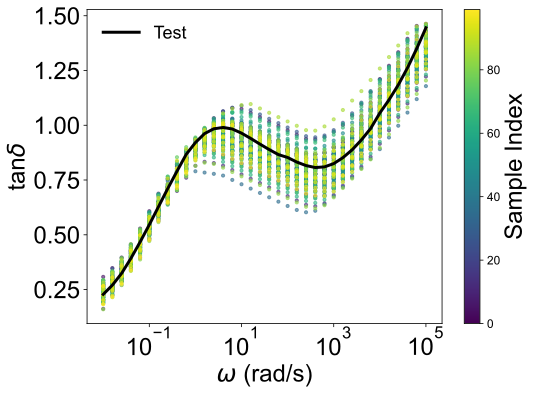

In [38]:
X_data_valid_list = X_valid_list

# 假设 X_data_valid_list, X_valid, y1_valid, y_scaler, device 均已定义
# 加载模型
model_pinn = [torch.load('model/PFGs/model_l_pinn_pfgs'), torch.load('model/PFGs/model_nl_pinn_pfgs')]

# 创建图表
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 获取验证数据总数，用于颜色归一化
num_curves = len(X_data_valid_list)

# 遍历每个验证集数据进行预测并绘制
for i, X in enumerate(X_data_valid_list):
    X_valid_device = X.to(device)
    # 预测输出：两部分模型输出相加
    y_MF_valid = model_pinn[1](X_valid_device) + model_pinn[0](X_valid_device)
    y_MF_valid_denorm = y_scaler.inverse_transform(y_MF_valid.detach().cpu().numpy())
    
    # 根据当前索引计算渐变颜色
    color = plt.cm.viridis(i / (num_curves - 1))  # i 从 0 到 num_curves-1

    # 绘制散点图，不重复添加图例
    ax.scatter(10**X_valid[:, 0], y_MF_valid_denorm, color=color, s=10, alpha=0.6)

# 绘制测试数据曲线（加粗黑色曲线）
ax.plot(10**X_valid[:, 0], y1_valid, color='black', linewidth=3, label='Test')

# 设置图表属性
ax.set_xscale('log')
ax.set_ylabel('tan$\delta$')
ax.set_xlabel('$\omega$ (rad/s)')
ax.legend(loc='upper left', frameon=False, fontsize=18)

# 添加颜色棒
norm = plt.Normalize(0, num_curves - 1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # 设置空数组以供颜色棒使用
cbar = fig.colorbar(sm, ax=ax, label='Sample Index')
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('prediction_results.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.show()

